In [1]:
# Instalación de cuDF, cuML, cuGraph y demás usando pip
!pip install cudf-cu12 cuml-cu12 cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00


In [2]:
#importar archivo
from google.colab import files
uploaded = files.upload()

Saving facebook_combined.txt to facebook_combined.txt


In [10]:
import cugraph
import cudf
import networkx as nx

G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())

# Convertir a cuGraph (de NetworkX a cudf dataframe)
edges = nx.to_pandas_edgelist(G)
edges_cudf = cudf.DataFrame.from_pandas(edges[['source', 'target']])

# Crear grafo cuGraph
G_cu = cugraph.Graph()
G_cu.from_cudf_edgelist(edges_cudf, source='source', destination='target')

Nodos: 4039
Aristas: 88234


In [35]:
#identificar como vienen los resultados
edges_df = G_cu.view_edge_list().to_pandas()
print(edges_df.columns)

Index(['source', 'target'], dtype='object')


Se detectaron 14 comunidades.


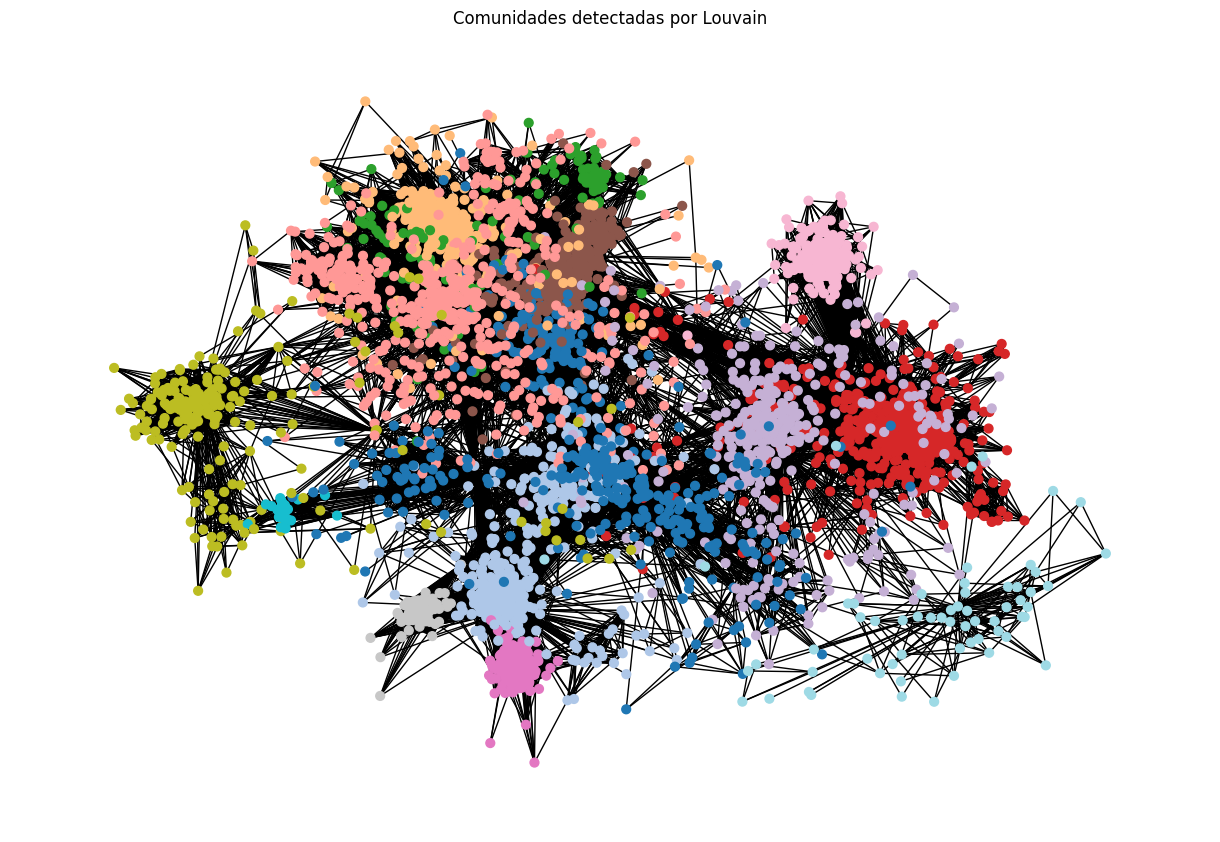

In [34]:
#LOUVAIN
import networkx as nx
import matplotlib.pyplot as plt
#implementar louvain
parts, _ = cugraph.louvain(G_cu)

#numero de comunidades
num_comunidades = parts['partition'].nunique()
print(f"Se detectaron {num_comunidades} comunidades.")

#mapear como un diccionario para graficar
comunidades = dict(zip(parts['vertex'].to_pandas(), parts['partition'].to_pandas()))
edges_df = G_cu.view_edge_list().to_pandas()

#crear grafo NetworkX desde aristas
G_nx = nx.from_pandas_edgelist(edges_df, source='source', target='target')

#colorear nodos por comunidad
colores = [comunidades[n] for n in G_nx.nodes()]

# 6. Dibujar grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos, node_color=colores, cmap=plt.cm.tab20, node_size=40, with_labels=False)
plt.title("Comunidades detectadas por Louvain")
plt.show()

In [33]:
#JACCARD: busca nodos similares (util para conectar amigos)
#cargar datos
edges_fb = cudf.read_csv("facebook_combined.txt", delim_whitespace=True, names=["src", "dst"])

#crear el grafo
G_fb = cugraph.Graph()
G_fb.from_cudf_edgelist(edges_fb, source='src', destination='dst')

#implementar Jaccard
jaccard_df = cugraph.jaccard(G_fb)

#filtrar los pares iguales
jaccard_df = jaccard_df[jaccard_df['first'] != jaccard_df['second']]

#eliminar duplicados (como (1,2) y (2,1)) si el grafo es no dirigido
jaccard_df['min_node'] = jaccard_df[['first', 'second']].min(axis=1)
jaccard_df['max_node'] = jaccard_df[['first', 'second']].max(axis=1)
jaccard_df = jaccard_df.drop(columns=['first', 'second'])
jaccard_df = jaccard_df.drop_duplicates(subset=['min_node', 'max_node'])

#ordenar
jaccard_df = jaccard_df.sort_values(by='jaccard_coeff', ascending=False)

#mostrar los pares más similares
top_similares = jaccard_df.head(50) #head numero de pares
print(top_similares)

#out: number, coeficiente, nodo menor, nodo mayor; El nodo 11, 12 y 15 se repiten bastante

/usr/local/lib/python3.11/dist-packages/cudf/io/csv.py:88: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  warnings.warn(


         jaccard_coeff  min_node  max_node
2195655            1.0      3481      3523
2300527            1.0      3639      3919
2570037            1.0      2902      3372
2598221            1.0       873       887
2691249            1.0      2817      3147
2716153            1.0       652       673
2760128            1.0        97       253
2760477            1.0       112       293
2812939            1.0        52       205
2813630            1.0        90       145
2817469            1.0       241       255
2821539            1.0       443       468
2822762            1.0       749       775
2841506            1.0      2382      2541
2843059            1.0      2704      2740
2856727            1.0      3854      3879
2860263            1.0      4006      4032
2860967            1.0        11        12
2860968            1.0        11        15
2860969            1.0        11        18
2860970            1.0        11        37
2860971            1.0        11        43
2860972    

In [40]:
#PAGERANK
#ejecutar pagerank
pagerank_df = cugraph.pagerank(G_fb)

# Mostrar los 10 nodos con mayor PageRank
top_pagerank = pagerank_df.sort_values(by="pagerank", ascending=False).head(20)
print(top_pagerank)
#out: indice, ID nodo, PageRank (la suma de todos da 1)
#los indices son mucho menores que en la red mas pequeña, ser influyente en una red mas grande es mas dificil

     vertex  pagerank
3      3437  0.007575
0       107  0.006888
1      1684  0.006309
4         0  0.006225
2      1912  0.003817
13      348  0.002317
139     686  0.002217
987    3980  0.002157
178     414  0.001782
12      483  0.001294
820     698  0.001292
430    3830  0.001187
278     376  0.000897
29     2047  0.000831
690      56  0.000810
804      25  0.000804
674     828  0.000794
754     322  0.000791
340     475  0.000781
711      67  0.000778


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


In [39]:
# Calcular centralidad de grado
degree_df = cugraph.degree_centrality(G_fb)

# Mostrar los 10 nodos con mayor centralidad de grado
top_degree = degree_df.sort_values(by='degree_centrality', ascending=False).head(20)
print(top_degree)
#out: nodo, distribucion de centralidad
#el nodo 107 es el que mas amigos tiene, el 11 12 y 15 tambien tienen buen nivel

    degree_centrality  vertex
0            0.517583     107
1            0.392273    1684
2            0.373947    1912
3            0.270926    3437
4            0.171867       0
5            0.145617    2543
6            0.144131    2347
7            0.125805    1888
8            0.121347    1800
9            0.116394    1663
10           0.115899    1352
11           0.115899    2266
12           0.114413     483
13           0.113422     348
14           0.111937    1730
15           0.110946    1985
16           0.110451    1941
17           0.109955    2233
18           0.109460    2142
19           0.108965    1431


In [33]:
#JACCARD: busca nodos similares (util para conectar amigos)
#cargar datos
edges_fb = cudf.read_csv("facebook_combined.txt", delim_whitespace=True, names=["src", "dst"])

#crear el grafo
G_fb = cugraph.Graph()
G_fb.from_cudf_edgelist(edges_fb, source='src', destination='dst')

#implementar Jaccard
jaccard_df = cugraph.jaccard(G_fb)

#filtrar los pares iguales
jaccard_df = jaccard_df[jaccard_df['first'] != jaccard_df['second']]

#eliminar duplicados (como (1,2) y (2,1)) si el grafo es no dirigido
jaccard_df['min_node'] = jaccard_df[['first', 'second']].min(axis=1)
jaccard_df['max_node'] = jaccard_df[['first', 'second']].max(axis=1)
jaccard_df = jaccard_df.drop(columns=['first', 'second'])
jaccard_df = jaccard_df.drop_duplicates(subset=['min_node', 'max_node'])

#ordenar
jaccard_df = jaccard_df.sort_values(by='jaccard_coeff', ascending=False)

#mostrar los pares más similares
top_similares = jaccard_df.head(50) #head numero de pares
print(top_similares)

#out: number, coeficiente, nodo menor, nodo mayor; El nodo 11, 12 y 15 se repiten bastante

/usr/local/lib/python3.11/dist-packages/cudf/io/csv.py:88: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  warnings.warn(


         jaccard_coeff  min_node  max_node
2195655            1.0      3481      3523
2300527            1.0      3639      3919
2570037            1.0      2902      3372
2598221            1.0       873       887
2691249            1.0      2817      3147
2716153            1.0       652       673
2760128            1.0        97       253
2760477            1.0       112       293
2812939            1.0        52       205
2813630            1.0        90       145
2817469            1.0       241       255
2821539            1.0       443       468
2822762            1.0       749       775
2841506            1.0      2382      2541
2843059            1.0      2704      2740
2856727            1.0      3854      3879
2860263            1.0      4006      4032
2860967            1.0        11        12
2860968            1.0        11        15
2860969            1.0        11        18
2860970            1.0        11        37
2860971            1.0        11        43
2860972    